# Förderhinweis

Dieses Dokument ist Teil des Lehrmaterials für die Fortbildung zum/zur **Berufsspezialist/in KI und Maschinelles Lernen.**

Die Entwicklung und Erprobung dieses Bildungsangebotes wurde vom Bundesministerium für Bildung und Forschung im Rahmen des InnoVET-Programms gefördert.

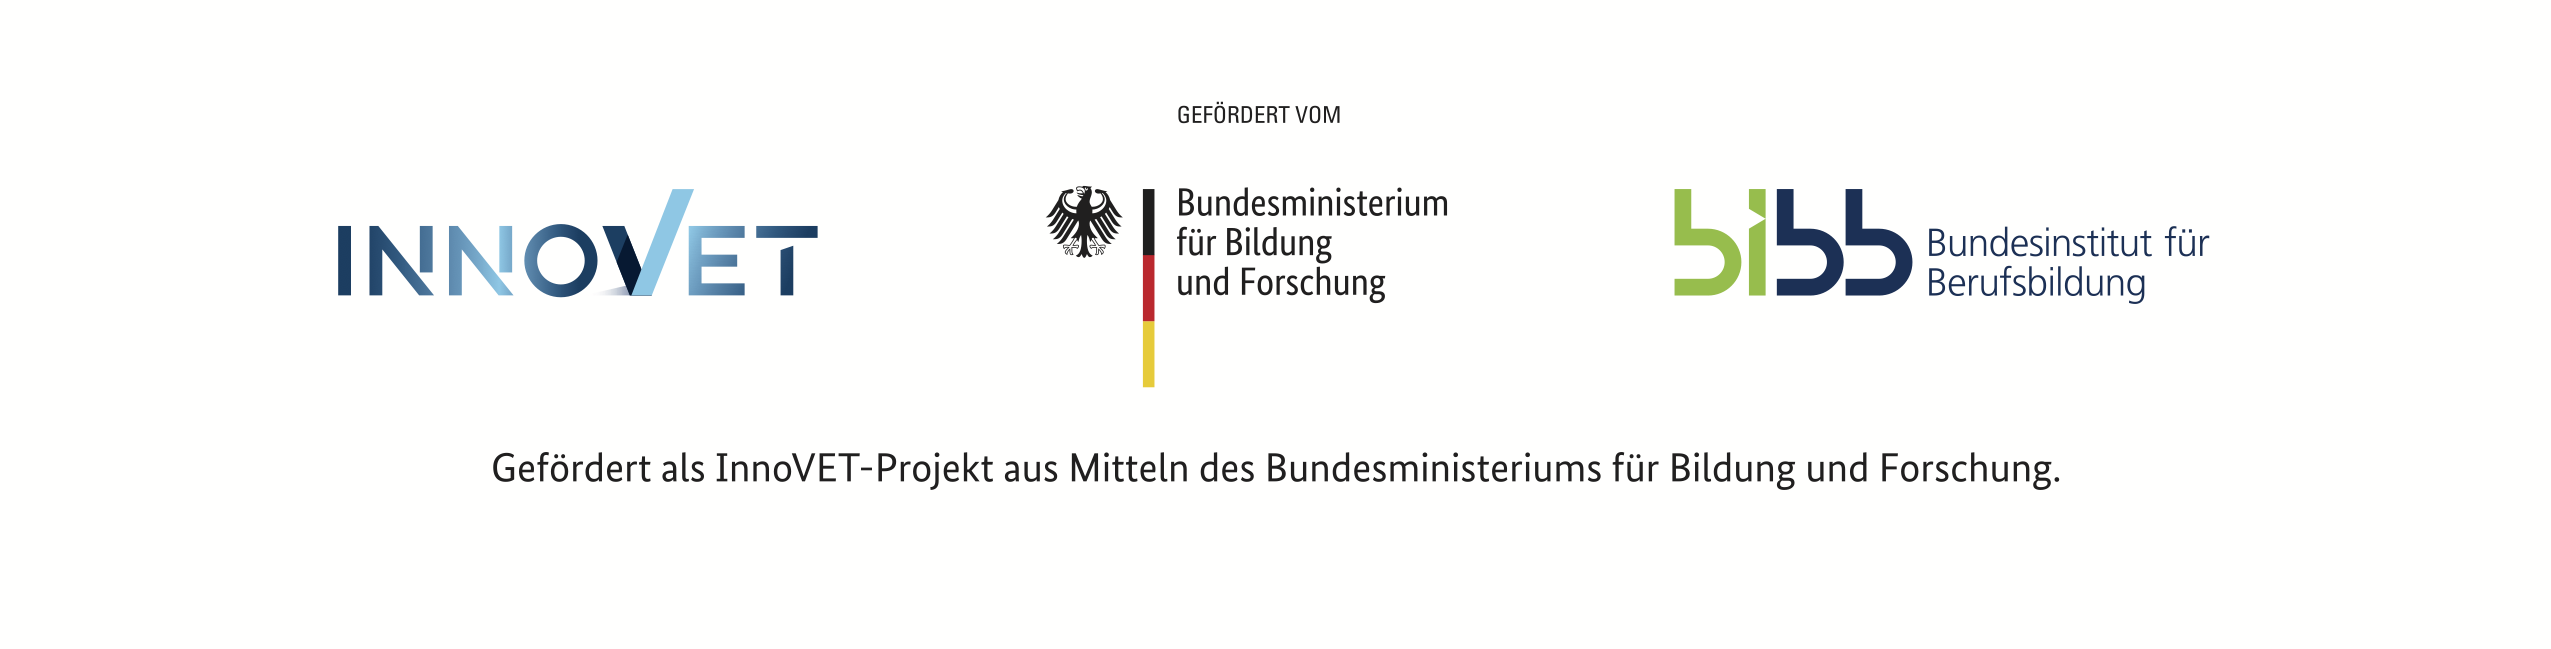

# Lizenzhinweis

Dieses Notebook "Transfer Learning" wurde von Antje Schweitzer, KI B3 / Universität Stuttgart, erstellt.

Das Werk, mit Ausnahme der oben abgebildeten Förderlogos, ist lizenziert unter [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/deed.de) (Namensnennung 4.0 International)

# Ziel dieses Projekts

In diesem Notebook geht es um **Transfer Learning**. Dabei werden bereits für andere, ähnliche Problemstellungen trainierte Modelle genutzt, um neue Aufgaben zu lösen. In diesem Notebook zum Beispiel wird ein komplexes Modell, das 1000 Klassen von Objekten in Bildern erkennen kann, trainiert, andere Klassen zu erkennen. Solche Modelle können anschließend durch **Fine Tuning** mit neuen Daten noch weiter verbessert werden. 

Beim Transfer Learning werden meistens die letzten Schichten des bereits trainierten Netzwerks weggelassen und durch neue Schichten ersetzt, die die Klassifikation der neuen Klassen lernen. Die Parameter des bereits trainierten Netzwerks werden beim Training nicht mehr verändert, es werden nur noch die Parameter der neuen Schichten gelernt. 

Wir nutzen in diesem Notebook eine Version des ResNet-Modells. Dieses Modell wurde auf den sogenannten ImageNet-Daten trainiert. Es hat 192 Schichten und kann 1000 Klassen von Objekten unterscheiden. Wir nutzen es dazu, die bereits aus dem letzten Notebook *Bilderkennung mit CNNs* bekannten Klassen von Blumen zu klassifizieren. Falls Sie keinen GPU-Prozessor benutzten konnten, war das Training eines eigenen einfachen Modells für diese 5 Klassen  wahrscheinlich zeitintensiv. Es sollte zum Beispiel auf einem "normalen" Google Colab-Account unter CPU-Nutzung mehr als eine Stunde benötigt haben, um eine Accuracy von um die 70% zu erreichen. Auch wenn eine Stunde Training in einem echten Anwendungsfall nicht viel ist (Trainingszeiten von mehr als einer Woche kommen durchaus vor) - für eine Aufgabe im Rahmen des Unterrichts mit Zugriff auf "normale" Ressourcen ist das lang. Wir werden sehen, dass wir durch die Nutzung des bereits trainierten ResNet-Modells schneller hohe Genauigkeiten erreichen. 

# Themen in diesem Notebook

* Netzwerkarchitektur 
    * Skip Connections bzw. Residual Connections
* Anwendung von Modellen für einzelne Vorhersagen
* Bedeutung der Rechenressourcen und CPU vs. GPU
* Output der obersten Schicht im Detail
* Kritischer Blick auf Trainingsdaten
    * Unschärfe bei der Festlegung der Klassen in den Trainingsdaten
    * Repräsentativität von Exemplaren
* Transfer Learning: Nutzung von bereits trainierten Modellen für neue Anwendungen
    * Laden von Modellen aus tensorflow
    * Erweiterung von Modellen um weitere Schichten
    * Einfrieren von Schichten in Modellen
    * Trainieren von Modellen auf neue Klassen
* Fine Tuning: 
    * Weitertrainieren von Modellen mit neuen Daten
* Laden und Speichern von Modellen

# ResNet-Modell laden

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
import os
import random

def set_random_state(seed_value):
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.compat.v1.set_random_seed(seed_value)
    tf.random.set_seed(seed_value)

# wählen Sie hier irgendeinen Wert
# der Code weiter unten wird immer myseed als Wert für set_random_state verwenden
myseed = 42

Wir importieren ein bereits trainiertes Modell namens ResNet50V2. Es findet sich, wie viele andere trainierte Modelle, im Modul `tensorflow.keras.applications`. Einen Überblick über alle in Tensorflow verfügbaren Modelle sowie dazugehörige Funktionen finden Sie in der [Tensorflow-Dokumentation dieses Moduls](https://www.tensorflow.org/api_docs/python/tf/keras/applications).  

Es gibt verschiedene ResNet-Modelle - sie stammen aus zwei verschiedenen Veröffentlichungen, beide von denselben vier Autoren. In den Veröffentlichungen werden verschiedenen Varianten der Architektur vorgeschlagen. Diese verschiedenen Architekturen werden durch verschiedene Funktionen instantiiert. Alle diese Funktionen sind Teil des Moduls `tensorflow.keras.applications`, werden aber noch einmal in eigenen Modulen zusammengefasst. Die Modelle der zweiten Veröffentlichung sind im Modul `tensorflow.keras.applications.resnet_v2` zusammengefasst. Wir nutzen hier das Modell, das durch die Funktion `ResNet50V2` instantiiert wird. Wir geben dabei an, dass die Gewichte (*weights* = Gewichte) genutzt werden sollen, die für die ImageNet-Daten gelernt wurden. Die Option `include_top` bewirkt, dass die oberste Schicht beibehalten wird, und `classes=1000`, dass sie 1000 Neuronen enthält, die den 1000 Klassen der ImageNet-Daten entsprechen. 

In [ ]:
resnet_model = tf.keras.applications.ResNet50V2(
    include_top=True,
    weights="imagenet",
    classes=1000,
    classifier_activation="softmax",
)

Wir sehen uns dieses Modell erst einmal genauer an, zunächst die Anzahl der Schichten. Die Liste der Schichten bekommt man über das Attribut `layers` des Modells. 

In [ ]:
len(resnet_model.layers)

Es handelt sich hier also um ein Modell, bei dem der Begriff *Deep Learning* gerechtfertigt ist: wir haben hier ganze 192 Schichten. Diese Schichten können wir uns auch ansehen: 

In [ ]:
resnet_model.summary()

Dem Modell-Überblick können wir ganz oben direkt eine wichtige Information entnehmen: es erwartet Input der Größe 224x224 Pixel. 

Die Betrachtung der Schichten zeigt, dass das Modell sehr viel mehr Schichten hat als die bisher betrachteten Modelle. Abgesehen davon sollten die Schichten relativ vertraut sein - es gibt Konvolutionsschichten, Batch Normalization, ReLU-Aktivierungsschichten sowie Pooling-Schichten. Was hier neu ist, sind die "Add"-Schichten - und diese sind das Besondere an ResNet. Die Add-Schichten addieren Output verschiedener Schichten und ermöglichen so verzweigende Netzwerke. Im Fall von ResNet werden sie genutzt, um Output weiter unten liegender Schichten zum Input späterer Schichten zu addieren. Dadurch fließt also Information nicht nur durch die dazwischen liegenden Schichten, sondern sie fließt zusätzlich an diesen Schichten vorbei. Solche Verbindungen werden manchmal als *Skip Verbindungen* bezeichnet: *skip* ist das englische Wort für *auslassen* oder *überspringen*. Eine weitere gängige Bezeichnung für solche Schichten, und die hier namensgebende Bezeichnung, ist *Residual Connections* - zu Deutsch etwa: *Rest-Verbindungen*. 

---

*Anmerkung für Profis: die Bezeichnung *Residual* ergibt sich (vereinfacht) folgendermaßen: normalerweise versucht man, mit einer Schicht eine Funktion *F* zu lernen, die zum Input *x* das (erwünschte) Output *y* vorhersagt, d.h. man sucht ein F, das für Input *x* den Output *y* ergibt:* 

```
y = F(x)
```

*Mit Residual Connections wird aber zum eigentlichen Output noch der Input addiert, d.h. es ergibt sich insgesamt der Output*

```
y = F(x) + x
```

*und damit lernt die entsprechende Schicht nicht den Output y, sondern die Differenz zwischen x und y: wenn man den Term oben umformt, bekommt man nämlich:*

```
F(x) = y - x
```

*Das heißt, das Netzwerk lernt sozusagen, die Differenz zwischen Input *x* und korrektem Output *y* vorherzusagen - und diese Differenz wird auch als Residuum (englisch: *Residual*) bezeichnet. Vielleicht erinnern Sie sich, dass wir auch bei der linearen Regression vom Residuum gesprochen haben - in dem Fall wurde damit die Differenz zwischen tatsächlichem Output und erwünschten Output bezeichnet. Dort handelte es sich also um den "Rest" oder Fehler, den man mit dem Modell nicht erklären konnte. Das Residuum hier ist etwas anders, aber auch hier geht es um eine Differenz zum Output.*

---



# Modell auf einzelne Bilder anwenden

## Einzelne Bilder laden und ansehen

Wir sehen uns als erstes *ResNet* in Aktion an. Um gezielt und bequem einzelne Bilder klassifizieren zu lassen, brauchen wir einerseits eine Funktion zum Laden einzelner Bilder sowie eine Möglichkeit, sie in Tensoren umzuwandeln - hierfür verwenden wir die Funktionen `load_img` und `img_to_array` aus `tensorflow.utils`. 

Außerdem müssen die entsprechenden Bilddaten genau so vorbereitet werden, wie ResNet das normalerweise erwartet. Dafür brauchen wir die Funktion `preprocess_input`, die über das Modul `tensorflow.keras.applications.resnet_v2` bereitgestellt wird. Dort findet sich auch die Funktion `decode_predictions`, die weiter unten für die Zuordnung der Ausgabe des Modells zu konkreten Klassen genutzt wird. 

Den Hinweis darauf, wie der Input aufbereitet werden muss, findet sich z.B. [in der Dokumentation der Funktion ResNet50V2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/ResNet50V2). Die Angabe der verfügbaren Funktionen findet man [in der Dokumentation des Moduls `resnet_v2`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2). 

Um uns Schreibarbeit zu ersparen, importieren wir alle vier Funktionen unter Angabe des Pfades innerhalb von tensorflow und können so anschließend einfach direkt die jeweiligen Namen der Funktionen verwenden. 

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

Zum Laden von Bildern mithilfe von `load_img` gibt es verschiedene Möglichkeiten. Eine ist es, ein Bild aus einem Verzeichnis auf dem eigenen Rechner zu laden. (Google Colab-Nutzer*innen können hier entweder wie in den vorigen Notebooks das temporäre Verzeichnis nutzen, das nur zur Laufzeit des Notebooks verfügbar ist. Dort können auch manuell problemlos einzelne Dateien hochgeladen werden. Alternativ können diese auch mit den bekannten Befehlen geladen werden. Ebenso ist die Nutzung des Google Drive möglich.)

Das Laden des gespeicherten Bilds erfolgt dann mit 

```
img = load_img('mein_bild.jpg', target_size=(224,224))
```
Es ist komfortabel, dass die Funktion `load_img` die Option `target_size` anbietet, mit der Bilder beliebiger Größe direkt in die für ResNet erforderlichen 224x224 Pixel umgewandelt werden können. 

Alternativ können mit `load_img` auch Bilder von einer URL geladen werden - in dem Fall wird ein beliebiger Name für das Bild angegeben sowie die URL. Wir laden hier probeweise ein Bild eines Elefanten.  Theoretisch sollte ResNet nicht nur Elefanten erkennen können, sondern dabei zwischen afrikanischen und indischen Elefanten unterscheiden können:

In [ ]:
img_url = 'https://upload.wikimedia.org/wikipedia/commons/9/9b/Afrikanischer_Elefant%2C_Zoo_Miami_1.jpg'

img = load_img(tf.keras.utils.get_file('mein_elefant',img_url), target_size=(224, 224))

Die folgenden Befehle zeigen das Bild an:

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img)

## Bild für ResNet vorbereiten und klassifizieren lassen

Um es von ResNet klassifizieren zu lassen, wandeln wir das Bild in einen Tensor um. Wir lassen uns anschließend die Form des Tensors anzeigen:

In [ ]:
x = img_to_array(img)
x.shape

Wie erwartet, haben wir einen Tensor mit 2 Dimensionen für das zweidimensionale Bild; eine weitere Dimension brauchen wir für die je 3 Farbwerte pro Pixel. Die Vorverarbeitungsfunktion für ResNet_V2 erwartet allerdings vier Dimensionen, da sie die Bilder immer in Batches verarbeitet. Wir erweitern mithilfe von `np.expand_dims` die Daten um eine weitere erste Dimension für den Batch - diese enthält dann eben nur das eine Bild, so dass sich insgesamt die Form (1, 224, 224, 3) ergibt:

In [ ]:
x = np.expand_dims(x, axis=0)
x.shape

Wir können nun die Vorverarbeitung nutzen und das Bild anschließend mithilfe der Methode `predict()` durch das Modell schicken (wir machen also einen Forward-Pass):

In [ ]:
# Vorverarbeitung
x = preprocess_input(x)

# Forward Pass
preds = resnet_model.predict(x)

Das Ergebnis alleine ist noch nicht aussagekräftig: wir bekommen eine Liste von Arrays von je 1000 Werten. Da wir nur ein Bild klassifiziert haben, hat diese Liste nur ein Element. 

Das darin enthalten Array ist das Ergebnis der Softmax-Funktion der obersten Schicht. Wir haben es hier also mit Wahrscheinlichkeiten zu tun: wir sehen für jede der 1000 ImageNet-Klassen, mit welcher Wahrscheinlichkeit sie in unserem Bild vorliegt. Wir sehen uns interessehalber die ersten 10 Werte dieses einen Listenelements an:

In [ ]:
preds[0,:10]

Man kann an den sehr niedrigen Werten erkennen, dass mit extrem hoher Sicherheit kein Objekt der ersten 10 Klassen im Bild entdeckt wurde. 

## Die Ausgabe von ResNet interpretieren

Um interpretieren zu können, welche Klasse am wahrscheinlichsten vorliegt, muss man wissen, welche Position welcher Klasse entspricht. Man sucht dann die höchste Wahrscheinlichkeit und kann aufgrund der Position dieser Wahrscheinlichkeit im Array zuordnen, um welche Klasse es sich handelt. Diese Information ist etwas schwierig aufzufinden - im Zweifelsfall in einer .json-Datei der tensorflow-Installation. 

Viel einfacher ist es, die Funktion `decode_predictions` zu nutzen, die vom entsprechenden ResNet-Modul bereitgestellt wird. Diese liefert die Namen und Wahrscheinlichkeiten der wahrscheinlichsten Klassen - wir geben hier an, dass wir die wahrscheinlichsten drei Klassen sehen möchten (`top=3`):

In [ ]:
# Ergebnisse zusammenfassen ergibt Tupel der Form (Klassen-ID, Klasse, Wahrscheinlichkeit) 
# ergibt ein Array pro klassifiziertem Objekt
print('Predicted:', tf.keras.applications.resnet_v2.decode_predictions(preds, top=3)[0])

Falls Sie das oben von Wikipedia geladene Bild eines afrikanischen Elefanten klassifiziert haben, sollte die Ausgabe in etwa so aussehen:

```
Predicted: [('n02504458', 'African_elephant', 0.8877413), ('n01871265', 'tusker', 0.11010406), ('n02504013', 'Indian_elephant', 0.002122623)]
```

Das Modell liegt also richtig: es vermutet mit ca. 89%iger Wahrscheinlichkeit einen afrikanischen Elefanten im Bild. Die zweitwahrscheinlichste Klasse, *Tusker*, ist eine Bemerkung wert. Im Englischen kann man mit *Tusker* alle Tiere bezeichnen, die Stoßzähne haben - also z.B. männliche Wildschweine (Keiler), aber eben auch Elefanten. In ImageNet finden sich unter den Bildern für *Tusker* sehr viele Bilder von Elefanten - insofern ist die mögliche Klassifizierung nicht verwunderlich und in dem Sinne auch nicht falsch. Dies zeigt aber ein Problem bei der Erstellung von Trainingsdaten: durch nicht sauber abgegrenzte Klassen ergibt sich Unschärfe. Hier spiegelt die Unschärfe den englischen Sprachgebrauch wieder - manchmal wird auf Elefanten eben mit dem Begriff *Tusker* verwiesen. Trotzdem strebt man beim Maschinellen Lernen normalerweise exakte Abgrenzungen an. Zu einem gewissen Grad wird die Unschärfe im Sprachgebrauch im ResNet-Modell durch die Wahrscheinlichkeiten modelliert: wenn man dieses Bild Menschen zur Klassifikation gibt, besteht ebenso die Wahrscheinlichkeit, dass sie sich für *Tusker* entscheiden - aber sicher ist die Wahrscheinlichkeit, dass sie das Bild als *Elephant* klassifizieren, sehr viel höher. Das Klassifikationsergebnis von ResNet spiegelt dies im Prinzip wider. 

Wir überprüfen noch kurz, wie man ohne die Funktion `decode_predictions` auf die Klasse schließen kann. Wir suchen dafür das größte Element aus dem Array heraus (zur Erinnerung: wir bekommen das Array für das (einzige) klassifizierte Bild, indem wir auf das erste Listenelement `preds[0]` zugreifen.)

In [ ]:
np.argmax(preds[0])

Die höchste Wahrscheinlichkeit ergab sich also für das Element mit Index 386 - und dieses ist, wie Sie diesem Überblick [der Machine Learning-Software der Waikato Universität Neuseeland über die ImageNet-Daten](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/) entnehmen können, die Klasse "Afrikanischer Elefant". Achtung, der Überblick stammt von einer anderen Quelle als Tensorflow, und insofern besteht keine Garantie für deren Übereinstimmung mit den von Tensorflow angenommenen Klassen. In unserem Fall scheint sich die Korrektheit der Liste aber zu bestätigen.  


## Praktisches Mini-Projekt

---

Suchen Sie sich für verschiedene Klassen der o.g. Liste Bilder heraus und lassen Sie sie klassifizieren - liegt ResNet immer richtig? 

Die Liste enthält auch das Gänseblümchen (*Daisy*). Suchen Sie sich das Bild eines Gänseblümchens - wird es korrekt klassifiziert? Probieren Sie es mit den anderen Blumenklassen aus dem letzten Notebook. Als was werden sie erkannt?

---

# Modell auf neue Daten anwenden

Wir wollen später das ResNet-Modell nutzen, um per Transfer Learning ein neues Model zur Erkennung der Blumen aus dem letzten Notebook zu trainieren. Vorher wollen wir interessehalber ausprobieren, wie gut die in unserem bekannten Datensatz enthaltenen Gänseblümchen von ResNet bereits erkannt werden. 


## Einen Datensatz laden


Falls Sie dieses Notebook auf Ihrem eigenen Rechner ausführen, haben Sie evtl. bereits beim letzten Projekt die Daten heruntergeladen und in einem Verzeichnis `data` gespeichert. 

Die folgenden Befehle sollten sowohl auf Google Colab als auch auf eigenen Linux- oder MacOS-Rechnern funktionieren. Sie laden die Daten automatisch herunter. Sie speichern die Daten in einem Unterverzeichnis `data`, wie im letzten Notebook. Falls Sie dieses Notebook auf Ihrem eigenen Rechner bearbeiten und es sich im selben Verzeichnis befindet wie das letzte Notebook, haben Sie diese Daten vermutlich schon in diesem Unterverzeichnis. In dem Fall brauchen Sie die nächste Code-Zelle nicht unbedingt auszuführen. 

Falls Sie Google Colabs nutzen, beachten Sie den Hinweis aus dem letzten Notebook, falls Sie Ihr Google Drive nutzen wollen. Ansonsten sollte der folgende Befehl aber funktionieren, um Ihnen die Daten für eine Sitzung verfügbar zu machen. 

Falls Sie nicht Google Colabs nutzen und auch weder Linux noch MacOS verwenden, legen Sie ggf. bitte manuell im Verzeichnis mit diesem Notebook ein Unterverzeichnis namens `data` an und entpacken sie die von __[hier](https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz)__ heruntergeladene Datei `flower_photos.tgz` dort. Wir gehen in diesem Notebook davon aus, dass die Daten in diesem Unterverzeichnis liegen.  


In [ ]:
# Überprüfen, ob Datei schon geladen, und laden, falls nicht
![ -f data/flower_photos.tgz ] || wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz -P data
!cd data; tar xfz flower_photos.tgz


Wir interessieren uns zunächst nur für die Gänseblümchen und erstellen einen Validierungs-Datensatz, der **nur** Gänseblümchen enthält. Dazu laden wir nur die Bilder, die sich im Verzeichnis `data/flower_photos/daisy` befinden. Das Ergebnis ist, wie im letzten Notebook auch schon, ein Objekt der Klasse `DataSet`.

Wir nutzen diese Gelegenheit auch noch, um zu verstehen, wie man `DataSet`-Objekte manipulieren kann.

Im letzten Notebook haben wir die Daten aus verschiedenen Unterverzeichnissen importiert. Durch die Angabe der Option `labels='inferred'` haben wir dabei erreicht, dass die Exemplare der verschiedenen Klassen als Label die Namen der jeweiligen Unterverzeichnisse bekamen (*inferred* bedeutet in etwa *abgeleitet* - die Klassennamen wurden also aus den Verzeichnisnamen abgeleitet.) 

Dies geht dieses Mal nicht, da wir keine Unterverzeichnisse haben. Wir müssen daher `labels=None` angeben. 

Wir lassen die Daten hier in unveränderter Reihenfolge (`shuffle=False`), damit wir später leichter nachvollziehen können, welcher Datenpunkt von welchem Bild stammt.

Wir laden außerdem die Bilder mit einer Auflösung von nur 180x180 Pixeln (`image_size = (180, 180)`), da wir diese Auflösung auch im Projekt mit den CNNs im letzten Notebook verwendet haben. Eine höhere Auflösung bewirkt längere Trainingszeiten. Wenn man keine `image_size` angibt, bekommt man per Default 256x256 Pixel (und erzielt auch etwas bessere Ergebnisse). 

In [ ]:
data_dir = 'data/flower_photos/daisy/'

daisy_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  image_size = (180, 180),
  labels=None,
  shuffle=False,
batch_size = 32)

## DataSets umformen

Man kann über DataSets mehr Information bekommen, indem man ihr Attribut `element_spec` ansieht:

In [ ]:
daisy_ds.element_spec

Wir entnehmen, dass dieses DataSet Elemente der Form (None, 180, 180, 3) enthält - die erste Dimension ist vorhanden, hat aber eine unbekannte Länge ('None'). Sie ist für Batches vorgesehen, und die Batchgröße ist hier nicht für alle Batches gleich, daher wird 'None' ausgegeben. 

DataSets sind Objekte, über die iteriert werden kann: sie sind Listen von Elementen, die Daten repräsentieren. Die Elemente sind häufig Paare von Daten mit zugehörigen Labels. In unserem Fall haben wir nur ein einzelnes Datenobjekt pro Batch, da wir bisher noch keine Labels zugewiesen haben. 

Wir iterieren mit `iter(daisy_ds)` über das ganze DataSet und lassen uns in jedem Schritt die Form des Elements anzeigen:

In [ ]:
for data_batch in iter(daisy_ds):
    print(data_batch.shape)

Wir haben also für alle Batches außer dem letzten einen Tensor der Form (32, 180, 180, 3) - er repräsentiert jeweils 32 Bilder mit je 180x180 Pixeln und 3 Farbwerten pro Pixel. Der letzte Batch enthält nur noch 25 Elemente, weil nicht mehr so viele Bilder vorhanden waren. 

Wie oben erwähnt, gehört normalerweise zu jedem Element noch ein Label, und damit wir diese Struktur auch für die nicht mit Labels bezeichneten *Daisy*-Daten erhalten, nutzen wir die Methode `map()` für DataSets und haben damit ein Beispiel, wie man DataSets umformen kann.  

Die Methode `map()` nimmt als Argument eine Funktion, die einzelne Elemente des DataSets als Input nehmen kann. Durch `map()` wird dann jedes Element des DataSets durch das Ergebnis der Anwendung der Funktion auf das jeweilige Element ersetzt. Wir definieren hier eine sehr einfache Funktion, die zu jedem Element zusätzlich noch das Label für Gänseblümchen hinzufügt. Sie bekommt als Eingabe also ein Element, und gibt dieses unverändert zurück, ergänzt aber zusätzlich noch ein Label. In unserem Fall wählen wir als Label immer die 985, da das der Klasse der Gänseblümchen bei ImageNet entspricht:

In [ ]:
# Funktion definieren
# Input ist x, Ausgabe x und das Label
def add_label(x):
    return x, 985

# auf alle Elemente des DataSet anwenden
daisy_ds = daisy_ds.map(add_label)

Wir haben nun Paare von Elementen in unserem DataSet. Diese bestehen je aus einem Batch unbestimmter Länge mit Tensoren der Form 180x180x3 (die Bilder), sowie einem Vektor unbestimmter Länge (die Labels):

In [ ]:
daisy_ds.element_spec

Bevor wir das ResNet-Modell auf diese Daten anwenden können, müssen wir die Bilder ins richtige Format bringen (ResNet erwartet 224x224 Pixel). Außerdem müssen die Daten so vorverarbeitet werden, wie ResNet das erwartet. Beides erledigen wir ebenfalls mithilfe der `map()`-Funktion.

---

*Anmerkung: Wir hätten die Bilder oben auch direkt im Format 224x224 laden können. Allerdings hätten wir dann bei der Erkennung und auch später beim Training leicht bessere Ergebnisse bekommen: Bilder mit 224x224 Pixeln enthalten mehr Information als Bilder mit 180x180 Pixeln. Wir wollen unten selbst noch ein Netzwerk trainieren, bei dem wir uns aus Effizienzgründen auf 180x180 Pixel beschränken werden. Um die Ergebnisse beider Netze objektiv vergleichen zu können, ist es wichtig, in beiden Fällen dieselbe Auflösung als Ausgangspunkt zu verwenden. Dadurch ist wirklich beides Mal gleich viel Information in den Bildern enthalten. Falls Sie sich beim Training bessere Auflösungen leisten können, passen Sie den Code so an, dass Sie oben beim Laden der Bilder direkt eine höhere Auflösung verwenden. Falls Sie sich für 224x224 entscheiden, brauchen Sie dann keine Umwandlung. Falls Sie sich für eine höhere Auflösung, wie z.B. den Default von 256x256, entscheiden, brauchen Sie die Umwandlung weiterhin - sie verkleinert in dem Fall die Bilder. Achtung, beide Auflösungen vergrößern die Trainingszeiten gegenüber 180x180.*

---

In [ ]:
# Paar von x (Daten) und y (Label) als Input
# x auf 224x224 bringen, und mit preprocess_input für ResNet vorbereiten
# y unverändert zurückgeben
def preprocess_and_resize_images(x,y):
    # preprocess_input auf Bilder im neuen Format anwenden und mit y zurückgeben
    return preprocess_input(tf.image.resize(x, (224, 224))), y

daisy_ds = daisy_ds.map(preprocess_and_resize_images)
daisy_ds.element_spec

Nun haben wir also alle Daisy-Bilder in einem Datensatz. Wir wenden jetzt ResNet auf den ganzen Datensatz an. Da das DataSet-Objekt Batches vorgibt, werden die Vorhersagen in genau diesen Batches gemacht. Da wir 20 Batches haben, wird deshalb am Ende der Ausführung 20/20 angegeben. 

Beachten Sie, dass die Anwendung des Modells auf den ganzen Datensatz dauern kann, falls Sie keinen Zugriff auf einen schnelle CPU oder auf eine GPU haben. Bei der Entwicklung dieses Notebooks ergab sich z.B. beim Einsatz der CPU auf Google Colab eine Ausführungsdauer von ca. 2 Minuten für die folgende Zelle. Bei der Ausführung mit der sehr schnellen CPU (nicht der GPU!) eines MacBooks mit Apple Silicon M2 Chip dagegen dauerte die Ausführung dagegen ca. 12 Sekunden. Noch schneller ging es unter der Nutzung der T4 GPU bei Google Colabs, dort dauerte die Ausführung nur 6 Sekunden. Dies unterstreicht die Bedeutung von Ressourcen beim Einsatz von wirklich "tiefen" Deep-Learning-Modellen. 

In [ ]:
results = resnet_model.predict(daisy_ds)

## Einzelne Ergebnisse genauer analysieren

Wir sehen uns das Ergebnis für die ersten 30 Datenpunkte an:

In [ ]:
daisy_decoded = tf.keras.applications.resnet_v2.decode_predictions(results, top=1)
daisy_decoded[:30]

Offensichtlich liegt das Modell in vielen Fällen richtig - aber es finden sich auch falsche Klassifizierungen wie *red_wine* (Rotwein), *groom* (Bräutigam), *croquet_ball* (Krocketball) usw. Wir sehen uns zum Spaß diese falsch klassifizierten Bilder an - man lernt dabei auch etwas über die Schwierigkeit, repräsentative, eindeutige und dennoch realitätsnahe Trainingsdaten zu finden. 

Aus den ersten 30 Bildern wurden folgende Bilder falsch klassifiziert: Das Bild mit Index 2 (Rotwein), das mit Index 4 (Bräutigam), sowie das mit Index 7 (Krocketball). Wir haben hier übrigens zufällig eine sehr gute Quote: nur 3 von 30 Bildern sind falsch klassifiziert, das entspricht einer Accuracy von 90% für diese 30 Exemplare. Bei Bräutigam und Krocketball ist sich das Modell übrigens nicht sehr sicher (mit 39.4 bzw. 26.7%). Beim Rotwein geht das Modell immerhin von einer Wahrscheinlichkeit von fast 70% aus (69.9%). 

Um gezielt falsch klassifizierte Bilder anzeigen zu können, packen wir alle Bilder und alle Vorhersagen in einen großen Tensor bzw. eine große Liste:

In [ ]:
# alle Bilder in einen Tensor, um per Index gezielt auf jedes Bild zugreifen zu können
daisy_bilder = tf.concat([x for x, y in daisy_ds], axis=0)
# alle Klassen in ein Array, um gezielt zugreifen zu können
# dafür aus allen Elementen in daisy_preds nur die Klasse herausholen
daisy_predicted_class = [vorhersage[0][1] for vorhersage in daisy_decoded]

In [ ]:
daisy_predicted_class[:30]

In [ ]:
plt.figure()

# Indizes der anzuzeigenden Bilder
bilder = [2, 4, 7]
#bilder = [34, 35, 44, 49, 54] # weitere "falsche Klassifizierungen" bei Verwendung von 180x180

# Grafik aufteilen:
# so viele Bilder in einer Zeile, wie die Länge der Liste von Indizes vorgibt
figure, panel = plt.subplots(1,len(bilder))

panel_index = 0
for i in range(len(bilder)):
    # Bild anzeigen
    img = tf.keras.utils.array_to_img(daisy_bilder[bilder[i]])
    panel[panel_index].imshow(img)
    # Titel ergänzen: falsche Klasse des Bilds
    panel[panel_index].title.set_text(daisy_predicted_class[bilder[i]])
    panel_index = panel_index + 1


Sehen Sie selbst: die Fehl-Klassifizierungen sind nicht völlig unplausibel - die Gänseblümchen im ersten Bild scheinen in einer rötlichen Flüssigkeit zu liegen, die auch noch hochspritzt wie Rotwein beim Einschenken. Gut möglich, dass ein Teil der Trainingsdaten für die Klasse Rotwein solche Bilder enthielt. Zur Erinnerung: hier war sich das Modell mit fast 70% recht sicher. Im zweiten Bild sieht man die Blumen im Haar einer dunkel gekleideten, von hinten fotografierten Person, die eine Art Jackett zu tragen scheint. Machen Sie im Internet eine Bildersuche für "groom" - Sie werden feststellen, dass viele von ihnen mit Blumen im Knopfloch eines dunklen Anzugs fotografiert werden. Hätten Sie übrigens die Bilder im Format 224x224 geladen, wäre dieses Bild ebenfalls falsch klassifiziert worden, allerdings dann als Haarspange, auch das sicher plausibel. Im dritten Fall wird das Bild von Rasen dominiert, und es ist ein roter Rock sichtbar. Krocketbälle sind rot und werden sehr häufig im Rasen liegend fotografiert... Immerhin war sich das Modell hier unsicher - beim Krocketball z.B. ergab das Modell eine Wahrscheinlichkeit von nur ca. 27%.

Wir haben uns oben von der Funktion `decode_predictions` nur die Wahrscheinlichkeiten für die jeweils wahrscheinlichste Klasse anzeigen lassen - ändern Sie auf `top=3`, dann werden Sie sehen, dass das Gänseblümchen als Klassifizierung für das erste Bild auch in Frage kam, allerdings errechnete das Modell eine Wahrscheinlichkeit von nur 1% hierfür. 

## Diskussion

---

👥👥👥 Diskutieren Sie die Fehlklassifizierungen. Sind sie komplett falsch? 

Sehen Sie sich weitere falsch klassifizierte Exemplare an. Sind die Fehler nachvollziehbar? Wäre die korrekte Klasse immerhin unter den Top 3 gewesen? 

Diese Bilder sind alle im Blumen-Datensatz und werden potentiell als Trainingsdaten für Gänseblümchen genutzt. Sind sie repräsentativ für Gänseblümchen? Falls nein: Wie sieht ein repräsentatives Bild für Gänseblümchen aus? 

Statt sich nur die Fehlklassifizierungen anzusehen: Gehen Sie alle Bilder durch, die angeblich Gänseblümchen darstellen. Den Code dafür finden Sie in der nächsten Zelle - ändern Sie die Variable `seite`, um andere Exemplare zu sehen. Sind Sie immer einverstanden, dass das Bild Gänseblümchen darstellt? 

Wie ist dieser Datensatz vermutlich entstanden, was denken Sie? Welche Konsequenz hat das für die Qualität der Vorhersagen? 

[Gänseblümchen kann man (in geringen Mengen) essen](https://de.wikipedia.org/wiki/Gänseblümchen#Verwendung_als_Nahrungspflanze). Würden Sie bedenkenlos jede Blume essen, die von diesem Modell als Gänseblümchen klassifiziert wird? 

Hätten Sie weniger Bedenken, wenn ein Botaniker oder eine Botanikerin vorher jedes Bild im Datensatz überprüft und ggf. die Klasse korrigiert hat? 

---

In [ ]:
plt.figure()
# n Bilder in einer Zeile
n=4
figure, panel = plt.subplots(1,n)

# Hier die Seitennummer von Hand verändern, um zu "blättern"
seite=30
panel_index = 0
for i in range(n):
    index = i+seite*n
    # Bild anzeigen
    img = tf.keras.utils.array_to_img(daisy_bilder[index])
    panel[panel_index].imshow(img)
    # Titel ergänzen: vorhergesagte Klasse des Bilds und Index in den Daten
    panel[panel_index].title.set_text(daisy_predicted_class[index]+"("+str(index)+")")
    panel_index = panel_index + 1


## Systematische Evaluierung der Ergebnisse für Gänseblümchen

Wir haben jetzt gesehen, wie gut das Modell die Klasse der Gänseblümchen vorhersagt. Sehen wir uns an, wie gut das Modell über alle Bilder im Datensatz ist. Dafür müssen wir wissen, welche Struktur das Ergebnis von `model_resnet.predict()` hat - wir hatten das Ergebnis `results` gespeichert:

In [ ]:
results.shape

Das Ergebnis ist eine Matrix mit 633 Zeilen - eine Zeile pro klassifiziertem Objekt. Die Matrix hat 1000 Spalten - eine pro Klasse. Sehen wir uns als Beispiel die erste Zeile an: sie zeigt einen Vektor mit sehr niedrigen Wahrscheinlichkeiten.

In [ ]:
results[0,]

Wählen wir für diese Zeile nun das Element mit dem Index der Klasse Gänseblümchen aus (985), nehmen also nur die Spalte 985, bekommen wir den einzigen größeren Wert:

In [ ]:
results[0,985]

Die Wahrscheinlichkeit für Gänseblümchen lag für das allererste Bild also bei fast 100%. 

Wir wählen jetzt für jede Zeile die Spalte mit der höchsten Wahrscheinlichkeit aus: dafür nutzen wir die Funktion `argmax` aus `numpy`. Wir haben die Funktion oben schon einmal benutzt, um in einem Vektor das größte Element zu finden. Dieses Mal haben wir aber eine Matrix, und wir müssen daher auch noch spezifizieren, dass wir nicht das eine größte Element in der gesamten Matrix suchen, sondern das größte Element jeder einzelnen Zeile. Wir geben `axis=1` an und suchen damit entlang der Dimension 1 (Spalten stellen hier die Dimension 0 dar, Zeilen die Dimension 1).

Der Vektor enthält anschließend die Indizes der jeweils größten Elemente, und man sieht direkt, dass hier meist korrekt die Spalte 985 für Gänseblümchen den größten Wert enthielt. 

In [ ]:
np.argmax(results, axis=1)

Wir können nun einen Booleschen Vektor erstellen lassen, der erfasst, welche Werte tatsächlich 985 sind. Die Werte "addieren" wir mit `sum` auf - dabei gilt `True` als 1 und `False` als 0. Wir bekommen also die Anzahl der Zeilen, für die das Maximum wirklich in Spalte 985 zu finden war. Das sind genau die korrekt erkannten Gänseblümchen. Wenn wir anschließend durch die Anzahl aller Zeilen teilen, bekommen wir also die Accuracy über alle Daten: ca. 83%. 

In [ ]:
sum(np.argmax(results, axis=1)==985)/len(results)

Mit 83% liegt das ResNet-Modell damit um mehr als 10% höher als die Accuracy, die Sie im letzten Notebook für die Differenzierung der 5 Blumenklassen erreicht haben sollten. Das ist insofern beeindruckend, als das ResNet-Modell nicht nur 5, sondern 1000 Klassen differenzieren kann. Dies liegt an der viel komplexeren Architektur des Modells. Ein Modell dieser Komplexität ist allerdings mit "normalen" Ressourcen nicht zu trainieren. 

Es gibt aber die Möglichkeit, das ResNet-Modell als Basis für eigene Modelle zu verwenden. Dafür sehen wir uns im nächsten Abschnitt das Thema **Transfer Learning** an. 

# Ein Modell mit Transfer Learning für neue Aufgaben trainieren

Wir wollen nun das ResNet-Modell nutzen, um alle fünf Blumensorten differenzieren zu können. (ResNet im Original erkennt leider nur die Gänseblümchen, es kennt keine Tulpen, Rosen, Sonnenblumen oder Löwenzahn.) 


## Daten laden


Dafür laden wir zunächst die Bilder aller Sorten in einen Trainings- und einen Validierungsdatensatz. Wir lassen dabei die Aufteilung in Trainings- und Validierungsdaten automatisch im Verhältnis 80:20 aufteilen (`validation_split=0.2`). Besser wäre es vermutlich, sich wie im letzten Notebook um eine ausgewogene Aufteilung in die Klassen zu kümmern - dies bleibt Ihnen hier aber als eigenes Projekt überlassen. 

Durch die Angabe `subset=both` bekommen wir die beiden DataSet-Objekte als Paar zurück, und daher speichern wir sie auch direkt als Paar in den Variablen `flowers_train, flowers_valid` und bereiten sie wie oben für den Einsatz mit ResNet vor. 

In [ ]:
data_dir = 'data/flower_photos/'

flowers_train, flowers_valid = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels="inferred",
  shuffle=True,
  validation_split=0.2,
  subset="both",
  seed=myseed,
  image_size=(180,180),
  batch_size = 32)

flowers_train = flowers_train.map(preprocess_and_resize_images)
flowers_valid = flowers_valid.map(preprocess_and_resize_images)

## ResNet-Modell laden und "einfrieren"

Wir laden wieder das ResNet-Modell, dieses Mal aber ohne die oberste Schicht (`include_top=False`). Diese Schicht erledigt bei ResNet die Unterscheidung der 1000 Klassen und hat 1000 Neuronen. Wir wollen nur 5 Klassen erkennen und brauchen daher eine oberste Schicht mit nur 5 Neuronen, die wir später selbst ergänzen und auch trainieren wollen. 

Wir legen außerdem fest, dass der ResNet-Teil des Modells nicht trainierbar sein soll - wir wollen alle Parameter des ResNet-Modells unverändert beibehalten. Dies bezeichnet man auch als "Einfrieren" der Parameter (engl. *Freeze*). 

---
**Achtung, diese Änderung des Attributs `trainable` wird erst weiter unten wirksam, wenn das Modell kompiliert wird.**

---

In [ ]:
resnet_model_transfer = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    classes=1000,
    classifier_activation="softmax",
)

# die Parameter des Modells sollen nicht trainiert werden
resnet_model_transfer.trainable = False

In [ ]:
resnet_model_transfer.summary()

In [ ]:
len(resnet_model_transfer.layers)

Wenn man die Zusammenfassung des Modells mit der oben vergleicht, fällt vielleicht auf, dass durch die Angabe von `include_top=False` nicht nur die alleroberste Schicht, sondern die beiden abschließenden Schichten ausgelassen wurden. Im nächsten Schritt ergänzen wir diese, angepasst auf unsere 5 Klassen. 


## ResNet in eigenes Modell einbinden


Wir definieren jetzt ein eigenes Modell, das zuerst das ResNet-Modell (also alle 190 übernommenen Schichten) enthält und ergänzen selbst eine GlobalAveragePooling-Schicht, die das Output der letzten Konvolutionsschicht zu einer flachen Struktur zusammenfasst, sowie eine abschließende Schicht für die 5 Klassen. Der Zusammenfassung des Modells kann man entnehmen, dass es nur 10245 trainierbare Parameter enthält - diese sind genau die Gewichte der letzten, neu ergänzten Schicht. 

In [ ]:
set_random_state(myseed)

# neues Modell aus ResNet plus 2 weiteren Schichten
transfer_model = tf.keras.Sequential([
    resnet_model_transfer,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation="softmax"),
])

transfer_model.summary()

Dadurch, dass wir oben bereits das gesamt ResNet-Modell eingefroren haben, ist diese Schicht in unserem neuen Modell nicht trainierbar. Dies können wir hier bestätigen, in dem wir für jede Schicht unseres Modell das Attribut `trainable` ausgeben lassen. Die Schicht wird effektiv allerdings erst eingefroren, wenn wir das Modell vor dem Training kompilieren, wie oben schon erwähnt. 

In [ ]:
for layer in transfer_model.layers:
   print(layer.trainable)

## Training des Transfer-Modells

Anschließend wird das Modell kompiliert und trainiert. Sie werden feststellen, dass das Training ziemlich lange dauert, auch wenn so wenige Parameter zu trainieren sind. Das liegt daran, dass der Forward Pass durch das ganze ResNet-Modell sehr rechenintensiv ist. Dieser Forward Pass ist nötig, um die Vorhersagen des Gesamt-Modells berechnen zu können. Nur der Backward-Pass, bei dem man im Training die Gewichte angepasst hätte, entfällt für die Schichten des ResNet-Modells (und dieser wäre noch viel aufwendiger.)

Wir trainieren daher nur für 3-4 Epochen, was auf Google Colabs unter der Nutzung der CPU 20-25 Minuten dauern sollte. Weiter unten sehen Sie den Verlauf mehrerer längerer Trainings mit Early Stopping. Das Training stoppte meist spätestens nach 12 Epochen - da wir `patience=3` verwenden, bedeutet das, das beste Modell wurde spätestens in Epoche 9 erreicht. Erfahrungsgemäß sind hier ca. 88-89% Accuracy zu erwarten, falls Sie mit den vorgeschlagenen Bildgrößen von 180x180 Ausgangsgröße gearbeitet haben. Dabei wurde meist in Epoche 3, 4 oder 5 bereits eine fast so hohe Validierungs-Accuracy erreicht wie am Ende des Trainings. Die Accuracy verbesserte sich in den folgenden Epochen auch kaum mehr. Die Details der drei Durchläufe finden Sie weiter unten. 

Falls Sie die Bilder direkt in der Auflösung 224x224 verwendet haben, kommen Sie vermutlich auf ca. 1% mehr, bei längerer Trainingszeit, und auf schätzungsweise noch einmal 1% mehr, falls Sie 256x256 verwendet haben. 

In [ ]:
set_random_state(myseed)
tf.keras.backend.clear_session()

transfer_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# transfer_history = transfer_model.fit(flowers_train, epochs=3, validation_data=flowers_valid)

# falls längeres Training gewünscht ist:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=3, restore_best_weights=True)
transfer_history = transfer_model.fit(flowers_train, epochs=30, callbacks=[callback],validation_data=flowers_valid)

Wir plotten zunächst den Verlauf Ihres evtl. kürzeren Trainings. Er sollte zeigen, dass die Accuracy auf den Validierungsdaten schon nach wenigen Epochen recht hoch ist (nahe an 87-88%). Falls Sie länger als 3 Epochen trainiert haben, sollten Sie auch feststellen, dass die Accuracy sich danach kaum noch verbessert hat. Insofern ist es durchaus sinnvoll, das Training aus Effizienzgründen auf wenige Epochen zu beschränken. 

In [ ]:
import matplotlib.pyplot as plt 

# Grafik mit der Entwicklung von Verlust und Accuracy im Lauf des Trainings
# eine Funktion definieren, die den gewuenschten Plot erzeugt
# braucht als Argument das Ergebnis des Trainings (der Funktion fit)
def plot_valid(history):

    # Liste der Epochen im Training, kann der Länge der Liste von Accuracy-Werten entnommen werden
    epochs = range(1,len(history.history['accuracy'])+1)

    # Liste der Accuracys auf den Trainingsdaten und auf den Validationsdaten
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    # Liste der Verlustwerte auf beiden Daten
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # als Grafik plotten
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Trainingsdaten')
    plt.plot(epochs, val_loss, label='Validationsdaten')
    plt.legend(loc='upper right')
    plt.title('Verlust')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Trainingsdaten')
    plt.plot(epochs, val_acc, label='Validationsdaten')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.ylim([0.7,1.0])
    plt.show()

In [ ]:

plot_valid(transfer_history)

Das Training des Modells dauert immer noch recht lange - bei 10 Epochen kommt man bei Google Colab mit der CPU auf ähnlich lange Zeiten wie beim Training eines selbst trainierten, einfachen Modells (z.B. aus dem Projekt im letzten Notebook). Allerdings erreichen wir hier mit dem Transfer Learning auf ResNet deutlich höhere Accuracys von ca. 87-88%, und beim kürzeren Training von ca. 20 Minuten über weniger Epochen immer noch auf fast ebenso gute Werte. Mit dem Modell aus dem letzten Notebook sollten Sie dagegen in mehr als einer Stunde nur auf um die 70% gekommen sein. 

Die Grafik unten zeigt drei Beispieldurchläufe, bei denen das Training mit Early Stopping beendet wurde, wenn sich der Verlust auf den Validierungsdaten über 3 Epochen nicht weiter verbesserte. Sie sehen die Entwicklung der dazugehörigen Accuracys in den drei Grafiken. Die Überschrift zeigt jeweils, in welcher Epoche das (lt. Verlust auf den Validierungsdaten) beste Modell erreicht wurde, und welche Accuracy es auf den Validierungsdaten erreichte. In allen drei Fällen wurde bereits früh eine dem besten Modell vergleichbare Accuracy erreicht: 

Beim Modell ganz links wurde bereits in Epoche 3 eine Accuracy von 88.4% erreicht, und in Epoche 4 sogar eine Accuracy von 88.9%. Damit lag die Accuracy in Epoche 4 noch über der am Ende erreichten Accuracy von 88.7%. (Allerdings war da der Verlust noch höher, darum wurde das Training auch fortgeführt.) 

Beim Modell in der Mitte ist die in Epoche 7 erreichte Accuracy von 89.2% auch die insgesamt höchste Accuracy, allerdings wurde derselbe Wert in Epoche 5 bereits schon einmal erreicht. 

Und beim Modell rechts wurde bereits in Epoche 4 eine Accuracy von 89.0% erreicht (aufgrund des da noch höheren Verlusts war die Accuracy beim finalen Modell mit 88.6% aber minimal niedriger.) 

In allen Fällen hätte man also mit 4 oder 5 Epochen ein fast genauso gutes Modell erreicht. 

Beachten Sie übrigens, dass in allen drei Fällen Overfitting zu erkennen ist. Sie können eine leichte Verbesserung erreichen, indem Sie vor der GlobalPooling-Schicht eine Dropout-Schicht einbauen. Ebenso hilft es möglicherweise, in Ihrer abschließenden Schicht L2-Regularisierung zu verwenden. Es ist dennoch schwierig, das Overfitting hier zu vermeiden, ohne insgesamt die Performanz zu verschlechtern. Insofern ist es hier auch wirklich sinnvoll, mit Early Stopping nach wenigen Epochen das Training zu beenden. 

![output_3trainings.png](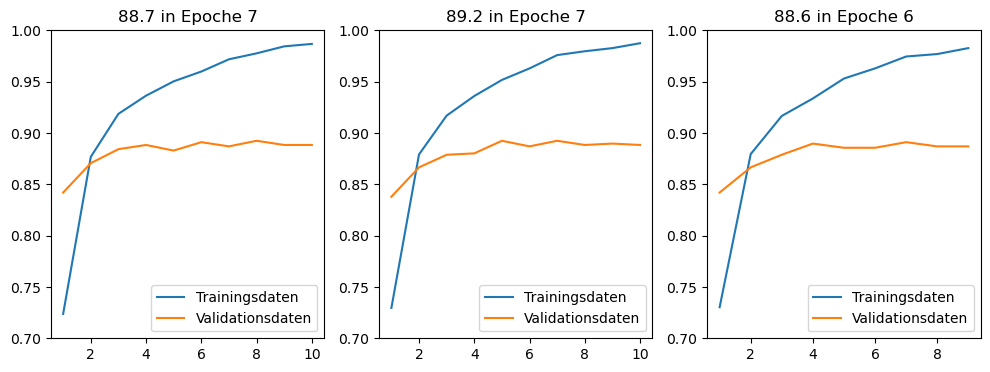
)

Nachdem wir nun möglicherweise viel Rechenzeit in das Training investiert haben, ist es wünschenswert, das finale Modell auch speichern und später wieder laden zu können. 

## Modelle speichern und laden

Tensorflow-Modelle kann man mit der Methode `save` speichern. Der Code unten speichert das Modell im tensorflow-Format (`save_format='tf'`) in dem Verzeichnis ab, in dem auch das Notebook liegt. Es wird dabei ein Ordner angelegt mit dem Namen, den Sie angegeben haben - hier also mit `resnet.transfer.tf`. 

Achtung, es sind gleich mehrere Warnhinweise fällig:

---

* Der Ordner benötigt um die 100 MB Speicherplatz
* Wenn Sie bei Google Colabs arbeiten, **wird dieser Ordner gelöscht, sobald die Sitzung von Ihnen oder von Google beendet wird.** 

---

Für Google Colab-Nutzer*innen: Sie finden den Order, wenn Sie links auf das Verzeichnis-Symbol klicken. Dort sollte neben dem bereits bekannten Verzeichnis `data` mit den Blumenbildern nun der Ordner auftauchen. Möglicherweise müssen Sie die Ansicht mithilfe des zweiten Symbols von links aktualisieren (Ordner mit rundem Pfeil). Wenn Sie das Modell dauerhaft speichern möchten und in Ihrem Google-Drive genügend Platz haben, verbinden Sie Ihr Google Drive (das geht auch über das dritte Symbol von links, den Ordner mit dem Google-Drive-Symbol). Führen Sie die Zelle aus, die dann automatisch eingefügt wird, und geben Sie beim Speichern als Namen `"/content/drive/My\ Drive/Colab\ Notebooks/resnet.transfer.tf"` an. 

In [ ]:
transfer_model.save("resnet.transfer.tf", save_format='tf')

Anschließend kann das Modell mit folgendem Befehl wieder geladen werden. Google Drive-Nutzer*innen müssen hier ggf. wieder den Pfad zum Google Drive angeben, nicht nur den Namen des Modells.

In [ ]:
transfer_model = tf.keras.models.load_model("resnet.transfer.tf")

## Auswertung der Accuracy nach Klassen

Wir wissen nun bereits, dass wir durch das Transfer Learning mit dem ResNet-Modell die Accuracy von um die 70% bei unserem komplett selbst trainierten Modell aus dem letzten Notebook auf ca. 88% gesteigert haben. Wir wissen aber nicht, wie groß genau die Verbesserung gegenüber dem Original-ResNet ist. Diese Frage kann auch nur für Gänseblümchen beantwortet werden - die anderen vier Blumenklassen kannte das Original-ResNet-Modell gar nicht. 

Die ca. 88% über alle Klassen sind jedenfalls höher als die Accuracy des Original ResNet für Gänseblümchen (diese lag bei 83%) - das Modell hat sich also auch für die eine Klasse verbessert, die es vorher bereits erkannte. (Allerdings "kennt" es dafür die anderen 999 Klassen von ImageNet gar nicht mehr, da es in der obersten Schicht nur noch 5 Neuronen für die 5 neuen Klassen besitzt...) Wir werden gleich sehen, dass die Accuracy pro Klasse etwas schwankt, wir wissen also noch nicht genau, wie gut das neue Modell speziell Gänseblümchen erkennt. 

Evaluieren wir zunächst über alle Klassen, welche Genauigkeit das von Ihnen trainierte Modell liefert - Sie sollten hier einen Wert von fast 88% oder mehr bekommen:

In [ ]:
tf1 = transfer_model.evaluate(flowers_valid)

Speichern wir nun alle Vorhersagen in einem Array.

In [ ]:
transfer_results = transfer_model.predict(flowers_valid)

Wir suchen jetzt in jeder Zeile (`axis=1`) nach der höchsten Wahrscheinlichkeit, um ein Array mit den Vorhersagen zu erhalten. Außerdem erstellen wir ein Array mit den korrekten Klassen. Wir lassen anschließend die Konfusionsmatrix erstellen, die zeigt, in welchen Fällen Vorhersage und korrekte Klasse nicht übereinstimmen. Sie sollten Konfusionsmatrizen aus den Notebooks zu Evaluationsmaßen sowie zur Aufteilung in Test- und Trainingsdaten kennen.  

In [ ]:
predicted = np.argmax(transfer_results, axis=1)

# ein Array mit den korrekten Klassen erstellen
# dafür die korrekten Klassen aus jedem Batch der Validierungsdaten zusammenfügen
labels = tf.concat([y for x, y in flowers_valid], axis=0)
# deutsche Namen der Blumen
blumen = ['Gänseblümchen', 'Löwenzahn', 'Rosen', 'Sonnenblumen', 'Tulpen']

# Funktionen für die Darstellung der Konfusionsmatrix laden
from sklearn.metrics import ConfusionMatrixDisplay

# Konfusionsmatrix anzeigen (Beschriftungen auf x-Achse aus Platzgründen drehen)
cm_plot = ConfusionMatrixDisplay.from_predictions(labels,predicted, display_labels=blumen,xticks_rotation='vertical')

![Konfusionsmatrix.png](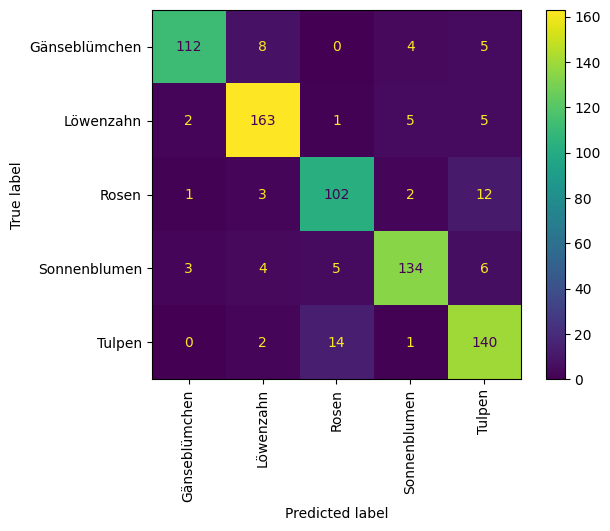
)

Oben sehen Sie eine Konfusionsmatrix des Beispielmodells, dessen Trainingsverlauf oben in der Grafik ganz links gezeigt wurde. Ihre Matrix hat sicher leicht andere Zahlen. 

Wir entnehmen der ersten Zeile dieser Matrix, dass es insgesamt 129 Gänseblümchen gab (die Zahlen in dieser Zeile ergeben addiert 129). In der ersten Zelle ganz links sehen Sie, wie viele davon auch korrekt als Gänseblümchen erkannt wurden. Die restlichen Zellen in dieser Zeile zeigen die Anzahl der falsch klassifizierten Gänseblümchen. 

Für die drei oben gezeigten Beispielmodelle ergab sich, dass das linke Modell 112 Gänseblümchen korrekt klassifizierte, das mittlere Modell 113 und das rechte 114. (Es gab in allen Fällen genau 129 Gänseblümchen, da alle drei Modelle auf denselben Trainingsdaten trainiert wurden. Sie haben in Ihren Daten vermutlich eine andere Gesamtzahl von Gänseblümchen - die Aufteilung wird ja per Zufall erledigt.) Damit ergeben sich Accuracys von 112/129=86.8%, 113/129=87.6% bzw. 114/129=88.4%. Damit liegen alle drei Modell deutlich über der Accuracy von 83%, die das Original-ResNet-Modell lieferte - es wurde also auch die Klasse etwas verbessert, die das Modell schon kannte. 

# Transfer-Learning mit weniger Schichten

Es ist nicht immer nötig, Modelle in ihrer vollen Komplexität für Transfer-Learning einzusetzen. Manchmal reicht es auch schon, einen Teil des Modells zu übernehmen und mehr Schichten wegzulassen als nur die Output-Schicht. 

Wir zeigen hier, wie das geht. Wir sehen uns dafür noch einmal die Architektur des Modells an und entscheiden, bis wohin die Schichten übernommen werden sollen. Das ResNet-Modell ist in größeren und kleineren Blöcken aufgebaut, was man auch der Benennung der Schichten entnehmen kann. Die größeren Blöcke heißen `conv1` bis `conv5`. In diesen Blöcken finden sich wiederum unterschiedlich viele kleinere Blöcke mit Konvolutionsschichten (`block1`, `block2` etc.). Das Modell verzweigt nach dem ersten größeren Block: es gibt ab `conv2` *Residual Connections*, die jeweils einen größeren Block überspringen. 

In [ ]:
resnet_model_transfer.summary()

## Teile eines Modells übernehmen

Wir versuchen hier, vor dem letzten Block abzuschneiden, d.h., wir übernehmen alle Schichten bis zur ersten Schicht von Block 5. Um zu erfahren, die wievielte Schicht das ist, lassen wir alle Schichten zusammen mit einem Index ausgeben:

In [ ]:
for i, layer in enumerate(resnet_model_transfer.layers):
   print(i, layer.name)

Der Ausgabe entnehmen wir, dass die Schicht mit Index 153 die letzte zu Block 4 gehörende Schicht ist. Wir definieren anschließend ein verkleinertes ResNet-Modell `smaller_resnet_model` mithilfe der Funktion `tf.keras.models.Model()`. Bisher haben wir zur Konfiguration von Modellen immer die Funktion `tf.keras.models.Sequential()` verwendet, die eine Liste von Schichten erwartet. Etwas anders funktioniert das hier: bei Modellen, die mit der Funktion `Model()` instantiiert werden, kann man Input und Output angeben. In unserem Fall ist das Input das Input des ResNet-Modells, also `resnet_model_transfer.input`, und das Output ist das Output dieses Modells in Schicht 153, also `resnet_model_transfer.layers[153]`. 

Auch hier frieren wir zunächst die Parameter ein und ergänzen eine Output-Schicht für 5 Klassen. Dafür bringen wir erst mit einer Pooling-Schicht den mehrdimensionalen Output der Konvolutionsschichten in eine flache Struktur. Ausgehend von der Erfahrung mit dem Overfitting oben bauen wir auch direkt eine Dropout-Schicht vor der abschließenden Schicht ein. 

In [ ]:
set_random_state(myseed)

smaller_resnet_model = tf.keras.models.Model(resnet_model_transfer.input, resnet_model_transfer.layers[153].output)
smaller_resnet_model.trainable = False

smaller_transfer_model_with_resnet = tf.keras.Sequential([
    smaller_resnet_model,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation="softmax")
    ])



In [ ]:
for layer in smaller_transfer_model_with_resnet.layers:
   print(layer.trainable)

In [ ]:
smaller_transfer_model_with_resnet.summary()

## Transfer Learning mit dem kleineren Modell

In [ ]:
set_random_state(myseed)
tf.keras.backend.clear_session()

smaller_transfer_model_with_resnet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=3, restore_best_weights=True)

transfer_history_smaller = smaller_transfer_model_with_resnet.fit(flowers_train, epochs=40, callbacks = [callback],validation_data=flowers_valid)

In [ ]:
tf2 = smaller_transfer_model_with_resnet.evaluate(flowers_valid)

In [ ]:
plot_valid(transfer_history_smaller)

In diesem Anwendungsfall zeigt sich, dass mit der Übernahme von nur 153 Schichten des ResNet-Modells die Accuracy des Transfer-Modells niedriger ausfällt. 

Dazu kommt, dass die einzelnen Epochen zwar minimal weniger Rechenzeit kosten, weil das Modell etwas weniger komplex ist. Dafür wird aber zumindest in unserem Anwendungsfall hier über mehr Epochen trainiert, bis das Modell konvergiert. 

Für die Anwendung hier lässt sich feststellen, dass die Nutzung des vollen ResNet-Modells sinnvoller zu sein scheint. 

Wir kommen hier trotz längeren Trainings meist nur noch auf ca. 85-86%. Achtung, manchmal liegt die Accuracy auch deutlich niedriger - wenn man Pech hat, startet das Training mit einer ungünstigeren Initialisierung. Mit einem anderen Random Seed sollten Sie in solchen Fällen andere Werte bekommen. Die Grafik unten zeigt einen Beispielverlauf für das Training. Zur besseren Vergleichbarkeit wurde für die Accuracy dieselbe Skala verwendet wie beim letzten Modell. Daher liegen die Kurven für die Accuracy niedriger als gewohnt. Es ist aber dafür sofort sichtbar, um wie viel besser das frühere Modell war. 

![output.smaller.transrer.model.png](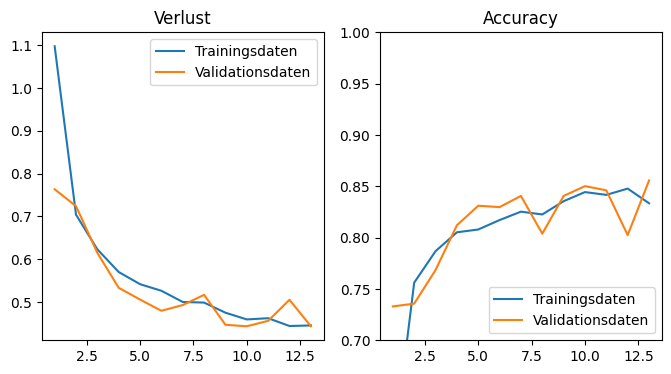
)

# Fine Tuning

Eine Möglichkeit, ein Transfer-Modell weiter zu verbessern, ist das sogenannte *Fine Tuning*. 

Beim Fine Tuning trainiert man ein bereits trainiertes Modell mit neuen Daten weiter. Dabei erlaubt man die Anpassung von Parametern des vortrainierten Modells. Manchmal werden dabei alle Parameter weiter trainiert; manchmal dagegen nur Parameter ausgewählter Schichten. Beides sehen Sie im Folgenden. 

Wir wollen hier das ResNet-Modell mit den neuen Bilddaten fine-tunen. Als Erstes sehen wir uns den Fall an, bei dem alle Parameter weiter trainiert werden. 


## Fine Tuning aller Schichten


Wir benötigen also ein Modell, das bereits konvergiert ist. Der Grund hierfür ist, dass wir  die Parameter nur noch minimal anpassen wollen. Daher starten wir nicht mit einer zufälligen Initialisierung, sondern bereits mit einem sehr guten Modell. Da das ResNet-Modell im Original die Kategorien von Blumen in unseren Bilddaten noch nicht kennt, müssen wir zunächst mithilfe von Transfer Learning ein gutes Modell trainieren. Da wir das oben bereits getan haben, können wir im Folgenden direkt das oben trainierte Transfer-Modell verwenden. 

Andernfalls wäre der erste Schritt, ein neues Transfer Modell zu trainieren, bei dem die Parameter von ResNet noch eingefroren sind. 

Das vorhin trainierte Transfer-Modell enthielt als erste Schicht das ResNet-Modell und darüber drei weitere Schichten: 

```
transfer_model = tf.keras.Sequential([
    resnet_model_transfer,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation="softmax"),
])
```

Wir verwenden es hier weiter. Für das Fine Tuning sollen die Parameter in allen Schichten angepasst werden, also auch in den Schichten des ResNet-Modells. 

Da wir alle Schichten des ResNet-Modells eingefroren hatten, ist in unserem Modell die erste Schicht nicht trainierbar. Dies können wir auch überprüfen, indem wir das `trainable`-Attribut aller Schichten ausgeben lassen:

In [ ]:
for layer in transfer_model.layers:
   print(layer.trainable)

Wir setzen jetzt gezielt für die erste Schicht dieses Attribut auf `True`, erlauben also die Anpassung der Parameter dieser Schicht im Training. 

In [ ]:
transfer_model.layers[0].trainable = True

Für das Fine Tuning sollte die Konfiguration des Modells fürs Training etwas geändert werden. Einerseits muss die Lernrate angepasst werden - das Fine Tuning soll sozusagen mit "Fingerspitzengefühl" erfolgen, daher senken wir die Lernrate auf 0.0001 oder sogar 0.00001 - probieren Sie aus, was bei Ihnen besser funktioniert. 

Außerdem kann es sein, dass das Modell schon nach sehr wenigen Epochen gut genug ist, um das Training mit Early Stopping zu beenden. Wir erlauben daher Early Stopping bereits ab Epoche 1. Es wäre zur Verkürzung des Trainings auch denkbar, abzubrechen, sowie sich der Verlust auf den Validierungsdaten nicht mehr verbessert, und nicht erst 3 Epochen ohne Verbesserung abzuwarten. Falls Sie wollen, setzen Sie den `patience`-Parameter entsprechend.

In [ ]:
set_random_state(myseed)
tf.keras.backend.clear_session()

# da wir das Attribut trainable geändert haben und auch die Lernrate ändern wollen, muss das Modell neu kompiliert werden
transfer_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=['accuracy'])

# das Modell ist oft schon nach weniger als drei Epochen gut genug, daher callback ab Epoche 1 erlauben
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=1, restore_best_weights=True)

history_finetuning1 = transfer_model.fit(flowers_train, epochs=30, callbacks = [callback],validation_data=flowers_valid)


In [ ]:
ft1 = transfer_model.evaluate(flowers_valid)

Das Training dauert jetzt pro Epoche sehr lange, da so viele Parameter zu trainieren sind. Auf dem schnellen Rechner, auf dem dieses Notebook entwickelt wurde, dauerte eine Epoche zum Beispiel ca. 3,5 Minuten, unter Nutzung der CPU. Auf Google Colab dauerte eine Epoche bei Nutzung der T4 GPU etwa eine halbe Minute. 

Die lange Trainingszeit lohnt sich aber: Man kann schon in der ersten Epoche eine deutliche Verbesserung feststellen. Insgesamt bringt das Fine Tuning hier meist eine Verbesserung von 2-3%. 

Bei einem Beispieltraining bei der Entwicklung dieses Notebooks verbesserte sich das Transfer-Modell zum Beispiel von 89.78% auf 92.23%, und zwar in der siebten Epoche. Dies dauerte allerdings etwa 35 Minuten, da für das Early Stopping insgesamt über 10 Epochen trainiert wurde. Dabei wurde bereits in der dritten Epoche nach 10 Minuten eine Accuracy von 92.37% auf den Validierungsdaten erreicht. Da der Verlust in dieser Epoche noch höher war als in Epoche 7, wurde es aber nicht als bestes Modell gespeichert. 

Bei anderen Beispieltrainings mit anderen Random Seeds gab es auch Fälle, in denen das Training kürzer dauerte, da weniger Epochen durchlaufen wurden, bis das Modell konvergierte. 


---
**Warum kann ein Modell mit einer besseren Accuracy einen höheren Verlust haben?**

Stellen Sie sich vor, ein Modell klassifiziert ein Gänseblümchen korrekt als Gänseblümchen, sagt dabei aber eine Wahrscheinlichkeit von nur 60% vorher. Damit ist die Klasse korrekt, d.h., für die Accuracy ist dieser Wert "perfekt". Für den Verlust allerdings nicht, denn 60% ist recht weit von den eigentlich erwünschten 100% entfernt. Das Modell kann übrigens korrekt sein und bei der Wahrscheinlichkeit noch weiter daneben liegen: ein Modell kann auch bei einer Wahrscheinlichkeit von unter 50% noch die korrekte Klasse vorhersagen, sofern alle anderen Klassen noch niedrigere Wahrscheinlichkeiten haben. Die Accuracy wäre dann immer noch "perfekt", aber der Verlust wäre noch höher.

--- 

Sehen Sie sich hier Ihren konkreten Trainingsverlauf und Ihre Accuracy an: Man sieht, dass das Modell unter Overfitting leidet; die Accuracy ist auf den Trainingsdaten schon nach der ersten Epoche fast perfekt. Es verbessert sich dennoch auch auf den Validierungsdaten um ca. 2-3%. 

Damit Sie die Veränderung der Accuracys auf den Validierungsdaten besser sehen können, definieren wir die Plot-Funktion diesmal so, dass sie nur den Verlauf bis zur besten Epoche zeigt, und dass die Accuracies zwischen 85 und 100% dargestellt werden, 

In [ ]:
import matplotlib.pyplot as plt 

# Grafik mit der Entwicklung von Verlust und Accuracy im Lauf des Trainings
# eine Funktion definieren, die den gewuenschten Plot erzeugt
# braucht als Argument das Ergebnis des Trainings (der Funktion fit)
def plot_valid_short(history):

    # Liste der Epochen im Training, kann der Länge der Liste von Accuracy-Werten entnommen werden
    # 3 weniger, um die Epochen nach der besten Epoche auszublenden
    epochs = range(1,len(history.history['accuracy'])+1-3)

    # Liste der Accuracys auf den Trainingsdaten und auf den Validationsdaten
    # die letzten drei Epochen ignorieren
    train_acc = history.history['accuracy'][:-3]
    val_acc = history.history['val_accuracy'][:-3]
    # Liste der Verlustwerte auf beiden Daten
    train_loss = history.history['loss'][:-3]
    val_loss = history.history['val_loss'][:-3]

    # als Grafik plotten
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Trainingsdaten')
    plt.plot(epochs, val_loss, label='Validationsdaten')
    plt.legend(loc='upper right')
    plt.title('Verlust')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Trainingsdaten')
    plt.plot(epochs, val_acc, label='Validationsdaten')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.ylim([0.85,1.0])
    plt.show()

In [ ]:
plot_valid_short(history_finetuning1)

In [ ]:
transfer_model.evaluate(flowers_valid)

## Fine Tuning ausgewählter Schichten

Eine weitere Möglichkeit ist es, nur die Parameter in den letzten Schichten zu trainieren. (Parameter tiefer liegender Schichten sind schwieriger zu trainieren, die Anpassungen dort sind oft sehr klein und haben wenig Effekt.) Außerdem ist es bei CNNs so, dass die unteren Schichten eher einfache Strukturen identifizieren, die für die Unterscheidung aller möglichen Objekte hilfreich sind (Kanten, Ecken, Spitzen etc.). Weiter oben liegende Schichten lernen dagegen eher problemspezifische Strukturen. Das heißt, sie lernen eher, welche Kombinationen der einfachen Strukturen für die vorliegenden Klassen typisch sind. Insofern ist es hier sinnvoll, nur die oberen Schichten auf die neuen Bilder anzupassen. 

In [ ]:
# Resnet-Modell neu laden (die Parameter des vorher geladenen Modells wurden oben durch Fine Tuning verändert)

resnet_model2 = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

set_random_state(myseed)
tf.keras.backend.clear_session()

# ResNet einfrieren
resnet_model2.trainable = False

# und in Transfer-Modell einbetten
transfer_model2 = tf.keras.Sequential([
    resnet_model2,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation="softmax"),
])

# für das Training des Transfer-Modells übliche Parameter für Callback und Optimierer
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=3, restore_best_weights=True)
transfer_model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Training
history_transfer_model2 = transfer_model2.fit(flowers_train, epochs=40, callbacks = [callback],validation_data=flowers_valid)

ft2_1 = transfer_model2.evaluate(flowers_valid)

print("\n\nTransfer abgeschlossen, jetzt beginnt das Fine Tuning!\n\n")


# Alle Schichten im Transfer-Modell trainierbar machen
transfer_model2.trainable = True
# Schichten im letzten Block von ResNet trainierbar machen
#for layer in resnet_model2.layers[:153]:
#   layer.trainable = False
for layer in resnet_model2.layers[153:]:
   layer.trainable = True

# Verlust für Early Stopping schon ab Epoche 1 beobachten
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=1, restore_best_weights=True)
# Lernrate niedriger machen
transfer_model2.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
#Training
history_transfer_model2_finetuning = transfer_model2.fit(flowers_train, epochs=40, callbacks = [callback],validation_data=flowers_valid)

ft2_2 = transfer_model2.evaluate(flowers_valid)


In [ ]:
print('Ergebnisse der Experimente bei Random Seed:',myseed)
print('jeweils Verlust, Accuracy und beste Epoche')
print('Transfer-Modell auf ResNet:',tf1, len(transfer_history.history['accuracy'])-3)
print('Transfer-Modell auf Teil von ResNet',tf2, len(transfer_history_smaller.history['accuracy'])-3)
print('Fine-Tuning (alle Schichten) des ersten Transfer-Modells:', ft1, len(history_finetuning1.history['accuracy'])-1)
print('Zweites Transfer-Modell:', ft2_1, len(history_transfer_model2.history['accuracy'])-3)
print('Fine-Tuning (obere Schichten) des zweiten Transfer-Modells:',ft2_2, len(history_transfer_model2_finetuning.history['accuracy'])-1)

In [ ]:
# flowers_train2, flowers_valid2 = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   labels="inferred",
#   shuffle=True,
#   validation_split=0.2,
#   subset="both",
#   seed=myseed,
#   image_size=(180,180),
#   batch_size = 32)

# # neues Modell aus ResNet plus 2 weiteren Schichten
# transfer_model2 = tf.keras.Sequential([

#     tf.keras.layers.RandomFlip("horizontal_and_vertical",input_shape=(180, 180,3)),
#     tf.keras.layers.RandomRotation(0.1, fill_mode="constant"),
#     tf.keras.layers.RandomZoom(0.1, fill_mode="constant"),

#     tf.keras.layers.Resizing(224,224),        

#     tf.keras.layers.Lambda(preprocess_input),
#     resnet_model_transfer,
# #    tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(5, activation="softmax"),
# ])


# set_random_state(myseed)
# tf.keras.backend.clear_session()

# transfer_model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=3, restore_best_weights=True)
# transfer_history2 = transfer_model2.fit(flowers_train2, epochs=30, callbacks=[callback],validation_data=flowers_valid2)

In [ ]:
# flowers_train2, flowers_valid2 = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   labels="inferred",
#   shuffle=True,
#   validation_split=0.2,
#   subset="both",
#   seed=myseed,
#   image_size=(180,180),
#   batch_size = 32)

# # neues Modell aus ResNet plus 2 weiteren Schichten
# transfer_model2 = tf.keras.Sequential([

#     tf.keras.layers.Resizing(224,224,input_shape=(180,180,3)),
#     tf.keras.layers.Lambda(preprocess_input),
#     resnet_model_transfer,
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(5, activation="softmax"),
# ])


# set_random_state(myseed)
# tf.keras.backend.clear_session()

# transfer_model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=3, restore_best_weights=True)
# transfer_history2 = transfer_model2.fit(flowers_train2, epochs=30, callbacks=[callback],validation_data=flowers_valid2)

In [ ]:

# resnet_model_transfer = tf.keras.applications.ResNet50V2(
#     include_top=False,
#     weights="imagenet",
#     classes=1000,
#     classifier_activation="softmax",
# )

# dropout = tf.keras.layers.Dropout(0.2, name="dropout")(resnet_model_transfer.output)
# globavpool = tf.keras.layers.GlobalAveragePooling2D(name="GlobAvPool")(dropout)
# dense_final = tf.keras.layers.Dense(5, activation="softmax")(globavpool) 

# new_model = tf.keras.Model(
#     inputs = resnet_model_transfer.inputs,
#     outputs = [dropout, globavpool, dense_final]
# )

# new_model.summary()

# Eigene Projekte

## Transfer Learning auf ResNet mit Dropout-Schicht und L2-Regularisierung

## Andere Auflösung

Laden Sie die Bilder in einer anderen Auflösung als 180x180. Falls Sie wenig Rechenkapazität haben, verwenden Sie eine niedrigere Auflösung. Falls Sie genügend Ressourcen haben, verwenden Sie statt dessen eine höhere Auflösung. Welche Ergebnisse bringt das Transfer Learning dann? Welche bringt das Fine Tuning? 

## Andere Bilder 

Suchen Sie sich andere Bilder. Es gibt im Internet jede Menge Quellen für Bilder. Evtl. können Sie sie direkt über eine Python-Bibliothek laden. Andernfalls können Sie sie wie hier auch aus verschiedenen Unterverzeichnissen laden. Wie gut werden Ihre Modelle für die neuen Bilder? Welche Klassen werden gut erkannt, welche weniger? (Lassen Sie sich die Konfusionsmatrix anzeigen.) Sind einzelne Fehler nachvollziehbar? (Lassen Sie sich einzelne falsch klassifizierte Bilder anzeigen.)

## Anderes vortrainiertes Netzwerk

Probieren Sie Transer Learning mit anderen Netzwerken. Die in Tensorflow verfügbaren Netzwerke finden Sie hier: [Tensorflow-Dokumentation vortrainierter Modelle](https://www.tensorflow.org/api_docs/python/tf/keras/applications). Sie können sich bei der Entscheidung für ein Modell auch daran orientieren, wie rechenintensiv die Modelle sind. Information dazu finden Sie in diesem [Überblick zu Modellen und Ressourcen direkt bei Keras](https://keras.io/api/applications/). Die Tabelle listet Rechenzeiten pro Forward Fass auf (letzte zwei Spalten). **Achtung, die Implementierung von Funktionen kann sich zwischen Keras und der in Tensorflow implementierten Version von Keras geringfügig unterscheiden.** Nutzen Sie daher die Tabelle bei Keras direkt nur zur Information über die benötigten Ressourcen.


## Apfel-Zitrusfrüchte

## Anwendungen in Ihrem Unternehmen

Suchen Sie eine mögliche Anwendung für Bilderkennung in Ihrem Unternehmen. Was ist denkbar? (Warensortierung, Erkennung von Mängeln an Werkstücken, Zugangskontrolle, ...) Was wäre auch umsetzbar? (Achtung, falls Sie Bilder von Personen erkennen wollen, müssen Sie sich an die Datenschutzregeln halten! Bei sicherheitskritischen Anwendungen sollten Sie sich auch rechtlich absichern - wer haftet, wenn z.B. die Zugangskontrolle versagt?)